In [1]:

# Author: Thiago Akio Nakamura
# E-mail: akionakas@gmail.com

# Import necessary classes and libraries
%matplotlib inline
import numpy as np
import pandas as pd
import numpy.ma as ma
from StringIO import StringIO
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

from matplotlib.colors import LogNorm
from matplotlib.colors import Colormap 
from scipy import linalg
from scipy.stats import randint
from operator import itemgetter

from time import time

from sklearn.mixture import MPPCA
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_blobs

In [2]:
# TODO deal with time 
# TODO deal with the names (elimated to generate a 2D array)
# The data should be on subdirectory called "data"
load_start = time()
orig_data = np.genfromtxt("/Users/AkioNakamura/Dropbox/PFC/Codes/fdd/data/bomba10.csv",
              dtype="|S32, float, float, float, float, float, float, float, float, float, float, |S32, float, float, float, |S32, |S32, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, float, |S32, float, float, |S32, |S32",
              skip_header=2,
              autostrip=True,
              delimiter=",",
              names=True)
names = orig_data.dtype.names
load_end = time()

print 'Took {} seconds to load the data.'.format(load_end-load_start)
print 'Loaded {} values from {} columns.'.format(orig_data.shape[0], len(names))

Took 17.5395970345 seconds to load the data.
Loaded 217441 values from 43 columns.


In [3]:
descriptions = np.genfromtxt("/Users/AkioNakamura/Dropbox/PFC/Codes/fdd/data/bomba10_description.csv",
              dtype="|S128",
              skip_header=1,
              skip_footer=5,
              autostrip=True,
              delimiter=",",
              usecols=(2))
print 'Following are the variables in the data:'
descriptions

Following are the variables in the data:


array(['P-57: A-T2610 - Vazao agua de injecao',
       'P-57: A-T2610 - Vazao agua de injecao',
       'P-57: P-T2610 - Rotacao bomba de injecao',
       'P-57: P-T2610 - DP filtro oleo lubrificante',
       'P-57: Potcncia hidraulica da bomba de injecao de agua P-T2611',
       'P-57: P-T2610 - Pressao oleo lubrificante',
       'P-57: P-T2613 - Pressao descarga',
       'P-57: P-T2610 - Pressao oleo lubrificante',
       'P-57: A-T2610 - Pressao descarga agua de injecao',
       'P-57: A-T2610 - Pressao succao agua de injecao',
       'P-57: PRESSURE SUCTION (WATER INJECTION PUMP A - A-T2610) :BYPASS',
       'P-57: Head - BOMBA P-T2610',
       'P-57: Horimetro Parcial - BOMBA P-T2610',
       'P-57: Numero de partidas da bomba BOMBA P-T2610',
       'P-57: P-T2611 - Status da bomba de injecao A',
       'P-57: WATER INJECTION PUMP A TRIPPED :BYPASS',
       'P-57: P-T2611 - Temperatura do Mancal Axial do Lado Ativo',
       'P-57: P-T2611 - Temperatura do Mancal Axial do Lado Inati

In [4]:
units = np.genfromtxt("/Users/AkioNakamura/Dropbox/PFC/Codes/fdd/data/bomba10_description.csv",
              dtype="|S8",
              skip_header=1,
              skip_footer=5,
              autostrip=True,
              delimiter=",",
              usecols=(3))
zero_span = np.genfromtxt("/Users/AkioNakamura/Dropbox/PFC/Codes/fdd/data/bomba10_description.csv",
              dtype="float, float",
              skip_header=1,
              skip_footer=5,
              autostrip=True,
              delimiter=",",
              usecols=(4,5))

Categorical Data. No plot shown.
Variable 11: 301072_T26_PSI_106_BYP - P-57: PRESSURE SUCTION (WATER INJECTION PUMP A - A-T2610) :BYPASS
Normal         207926
Bypassado        6516
I/O Timeout      2321
Intf Shut         402
Failed            276
dtype: int64
Categorical Data. No plot shown.
Variable 15: 301072_T26_PT2611 - P-57: P-T2611 - Status da bomba de injecao A
Normal         207926
Bypassado        6516
I/O Timeout      2321
Intf Shut         402
Failed            276
dtype: int64
Categorical Data. No plot shown.
Variable 16: 301072_T26_SXA_109_BYP - P-57: WATER INJECTION PUMP A TRIPPED :BYPASS
Normal         207926
Bypassado        6516
I/O Timeout      2321
Intf Shut         402
Failed            276
dtype: int64
Categorical Data. No plot shown.
Variable 38: 301072_T26_YHL_110 - P-57: S-T4101 - Disjuntor P-T2611
Normal         207926
Bypassado        6516
I/O Timeout      2321
Intf Shut         402
Failed            276
dtype: int64
Categorical Data. No plot shown.
Variable 4

/Library/Python/2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


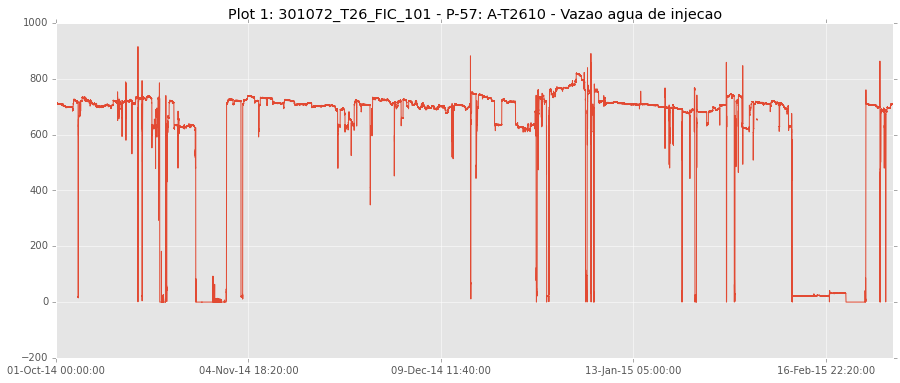

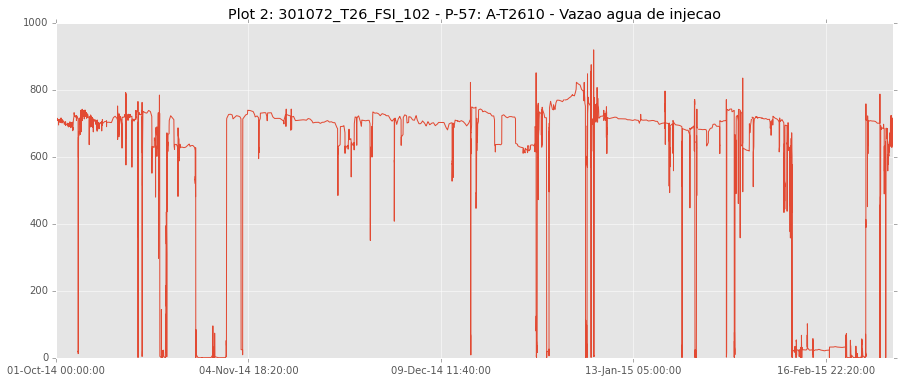

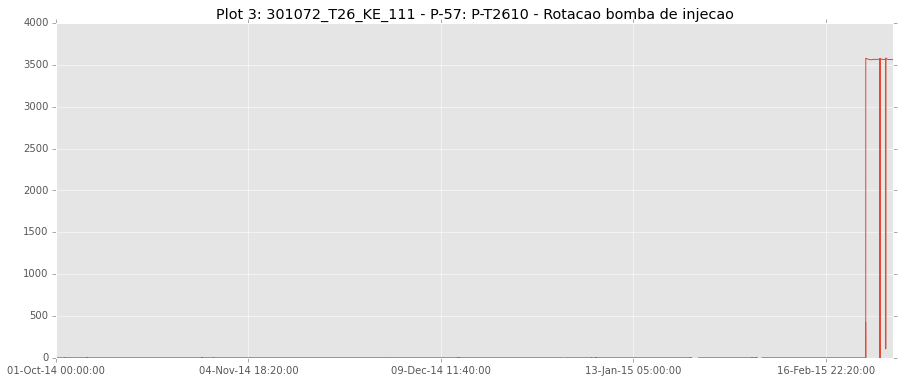

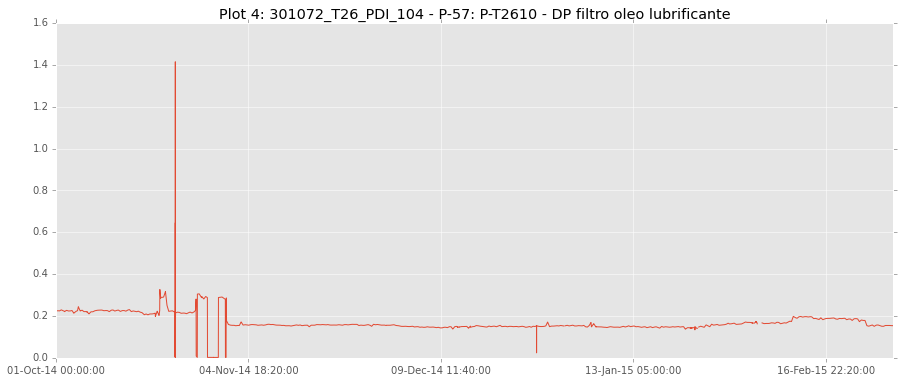

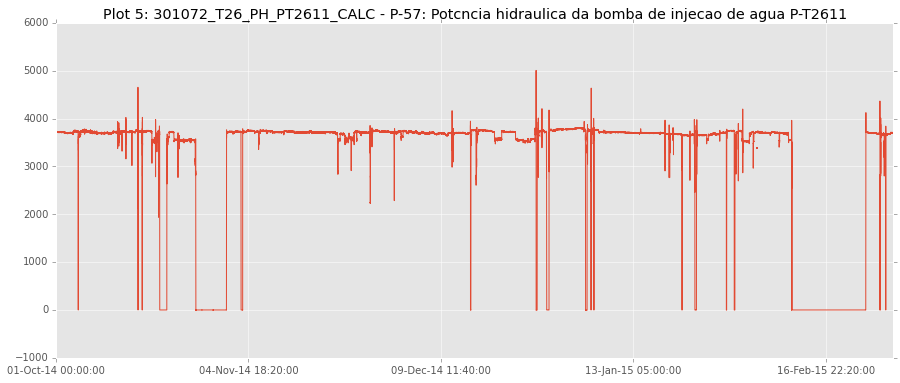

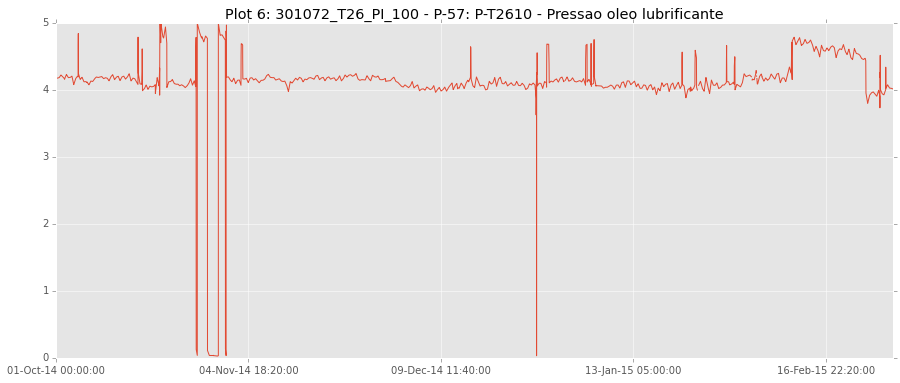

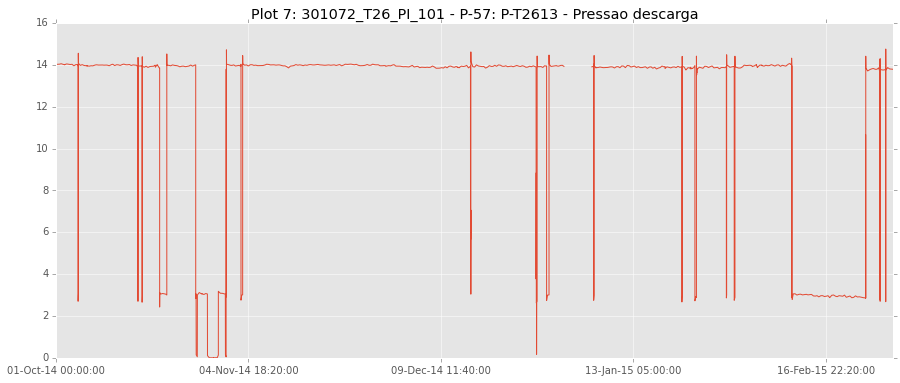

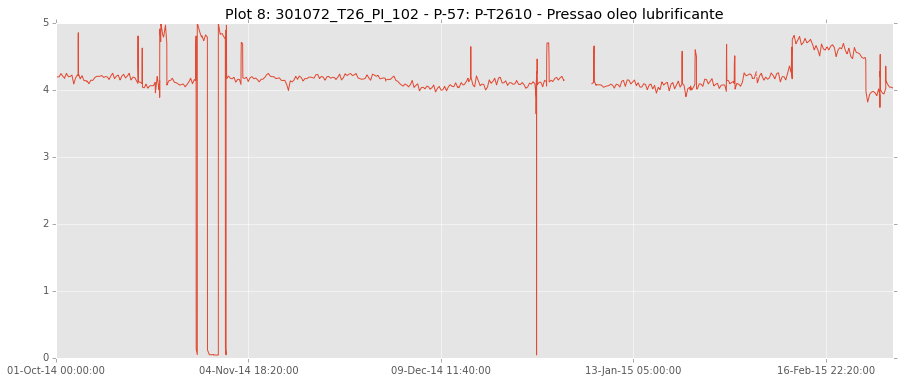

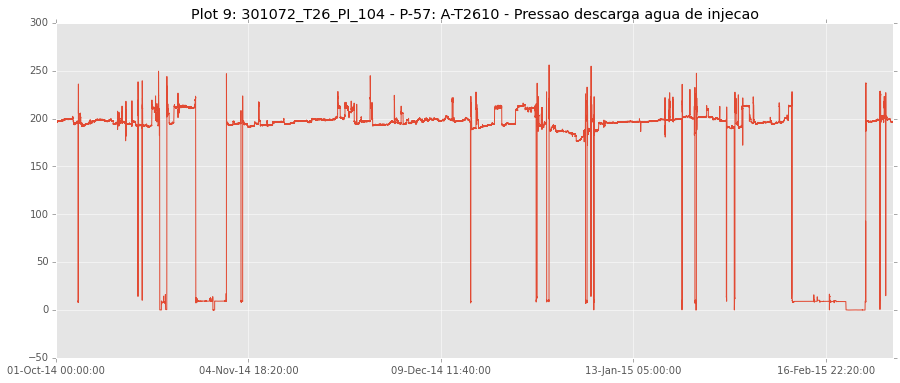

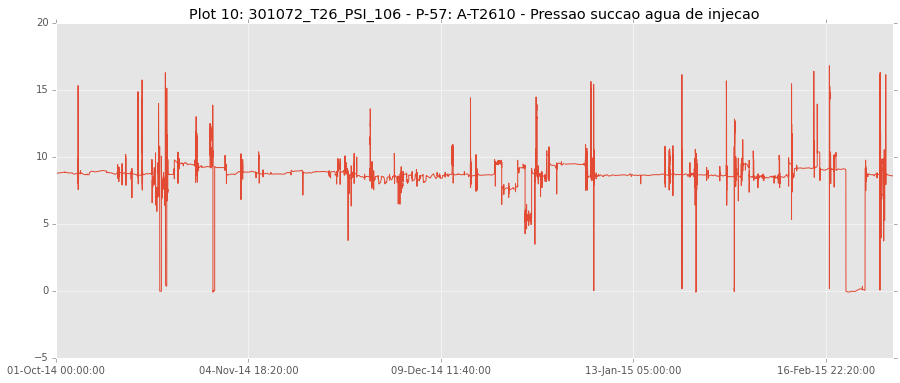

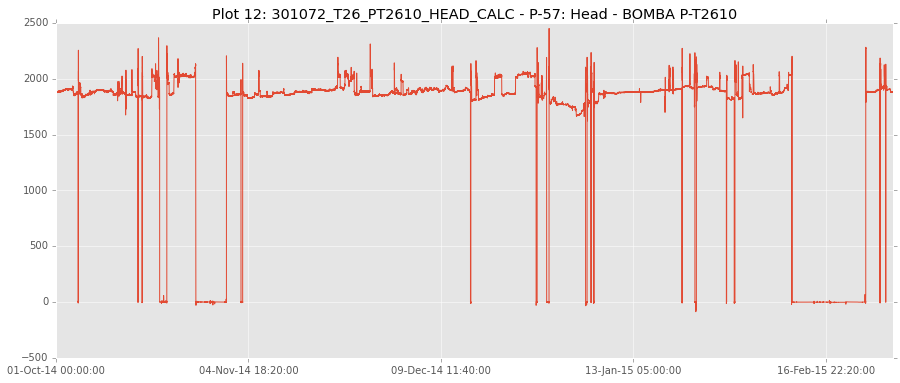

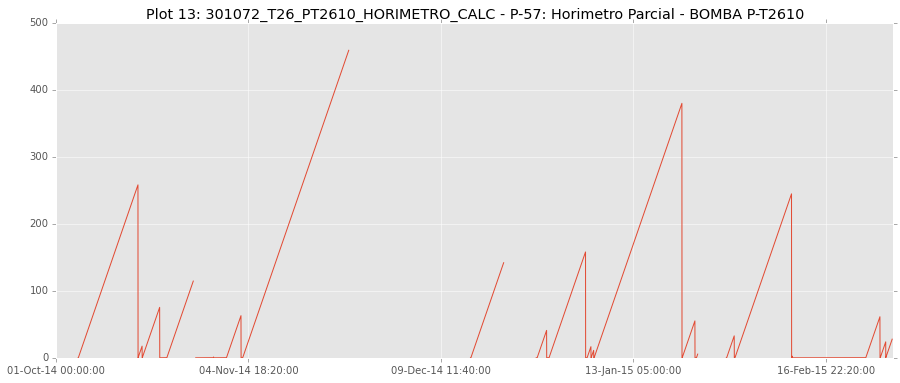

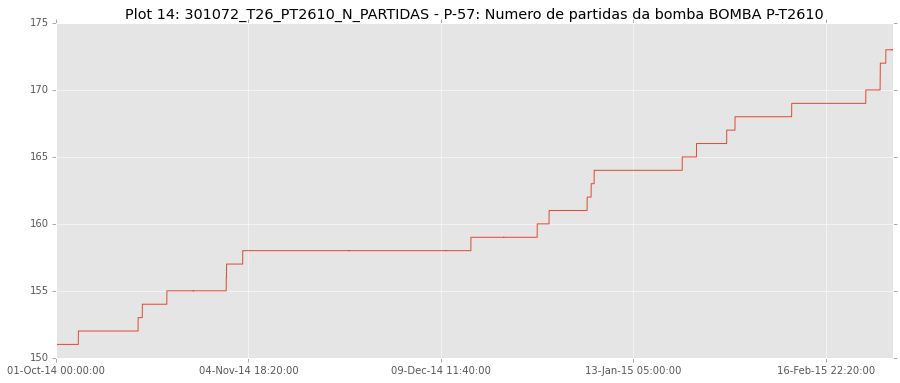

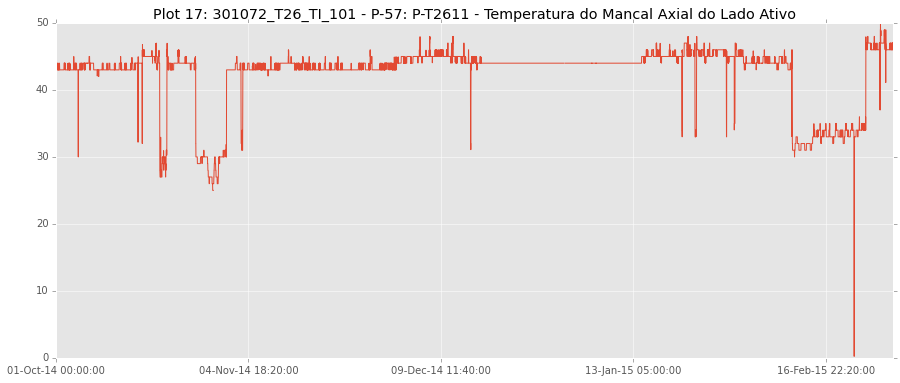

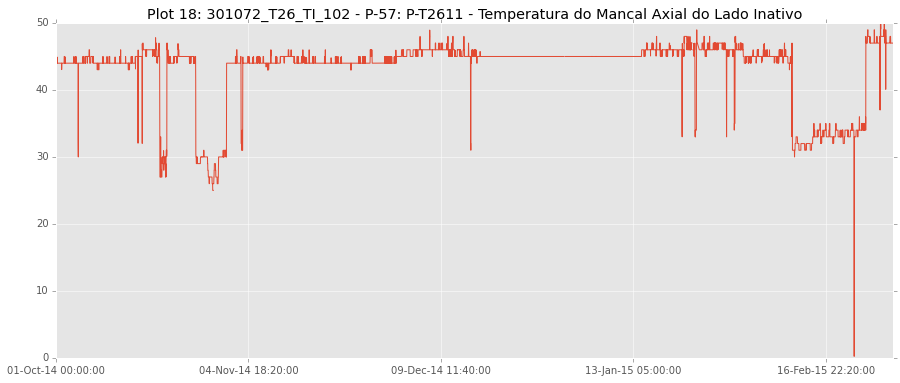

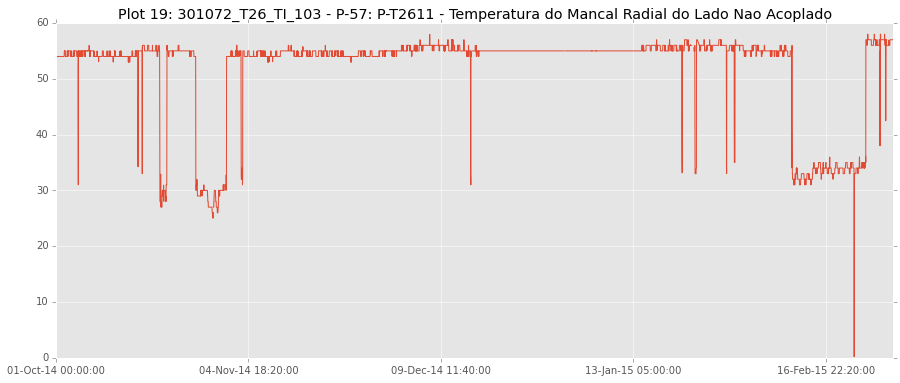

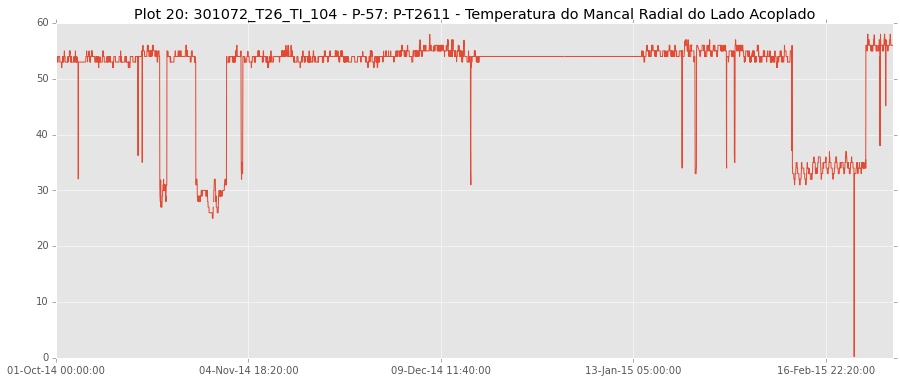

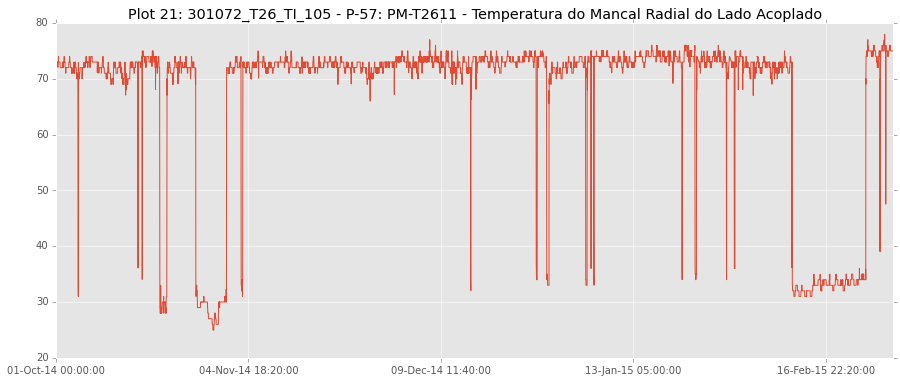

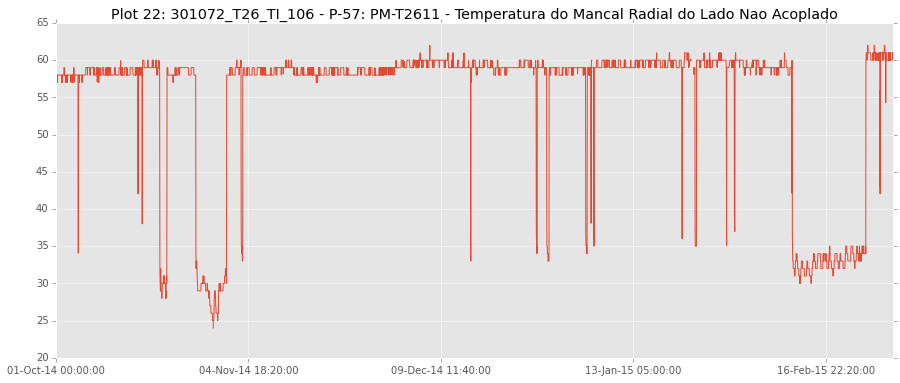

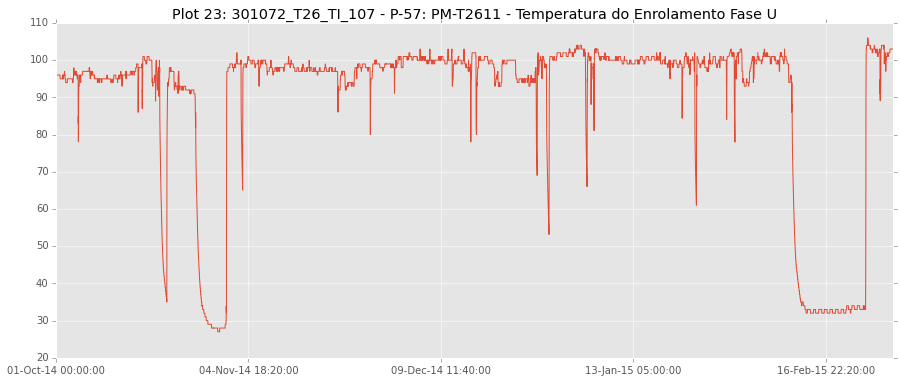

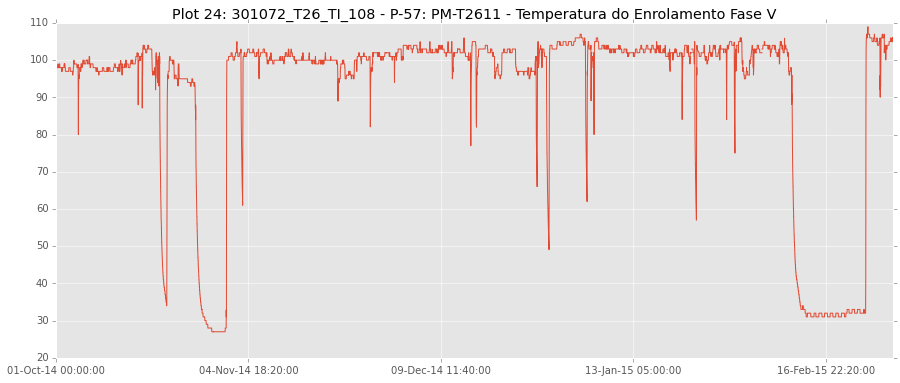

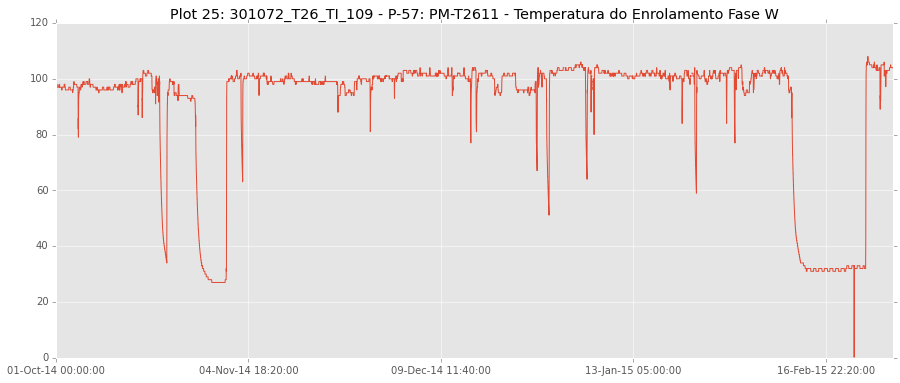

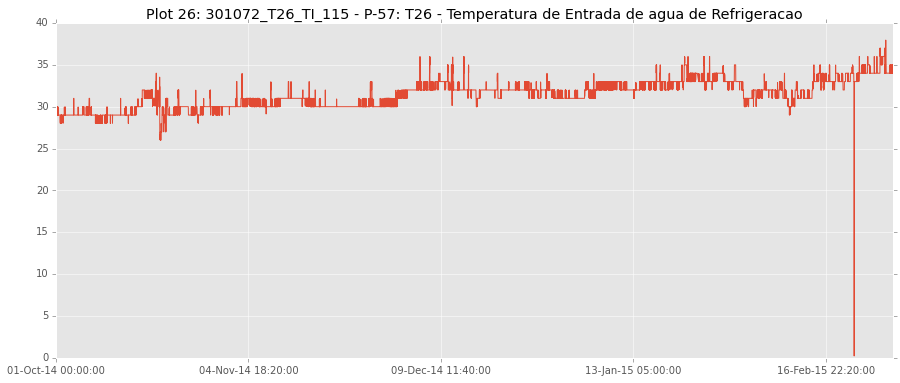

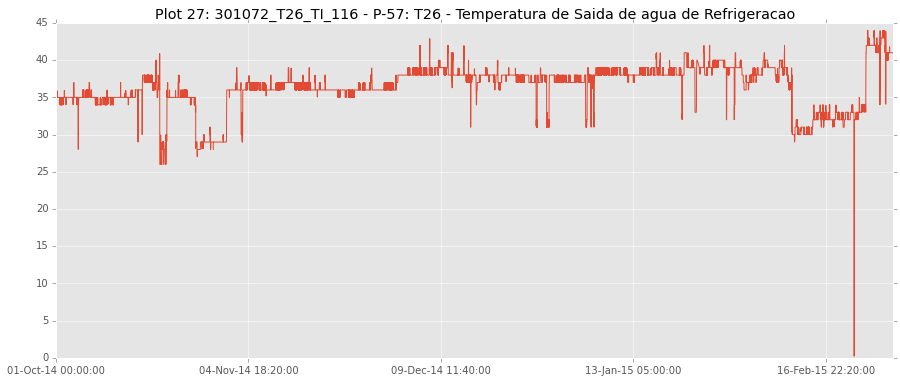

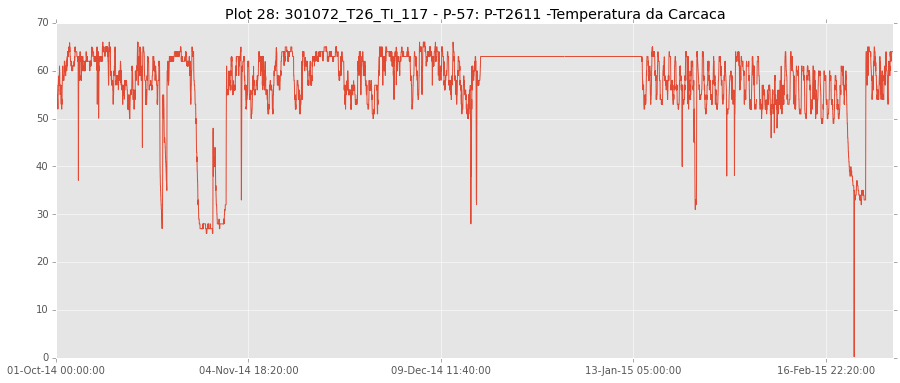

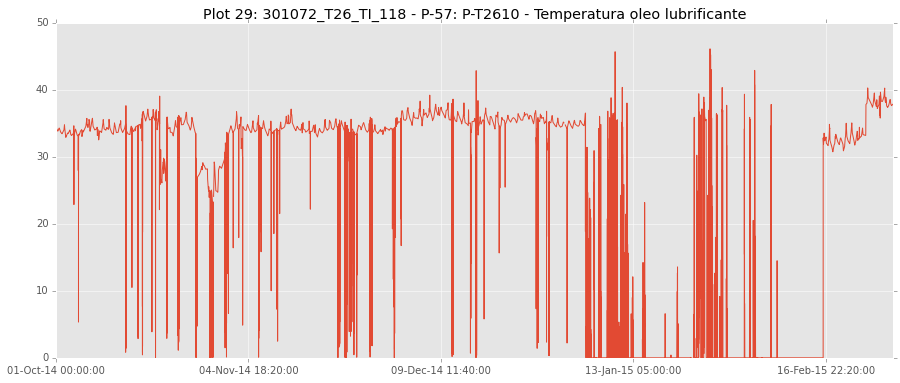

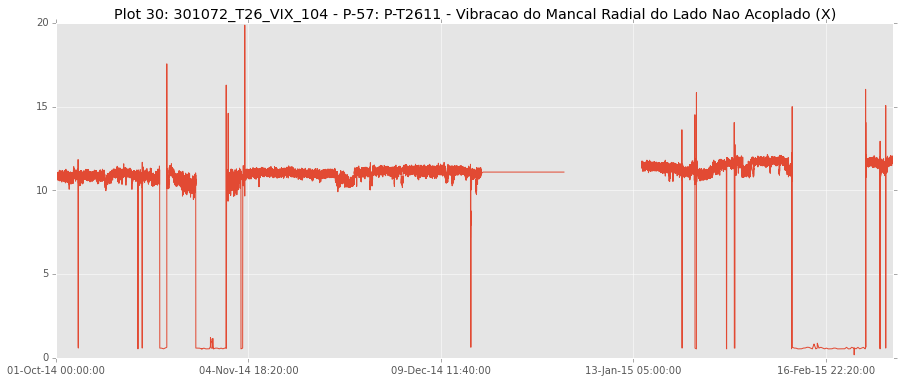

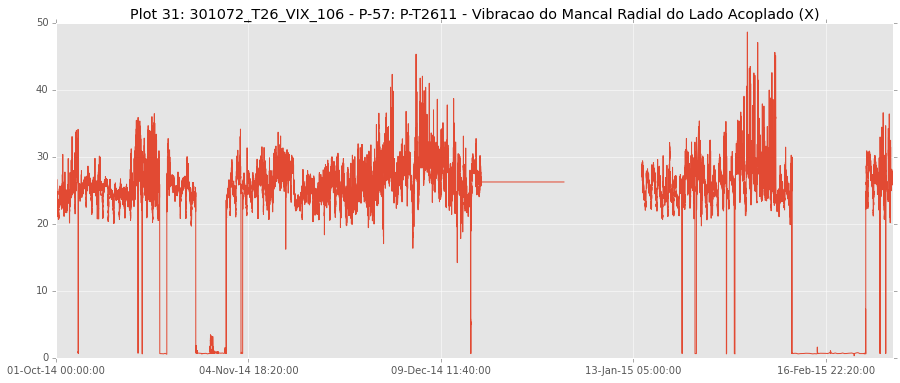

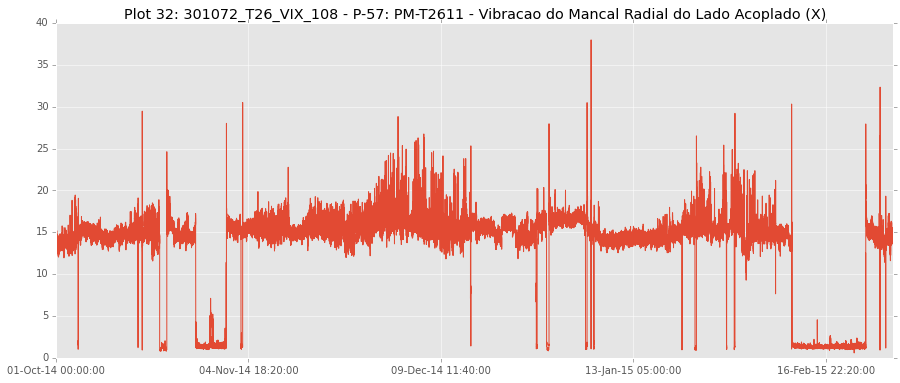

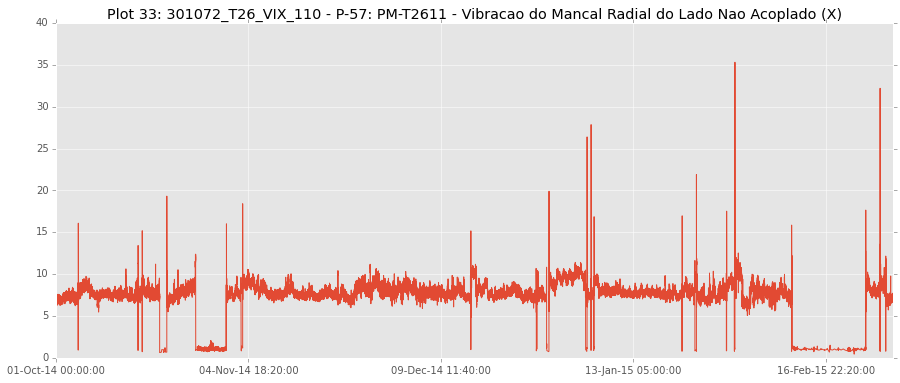

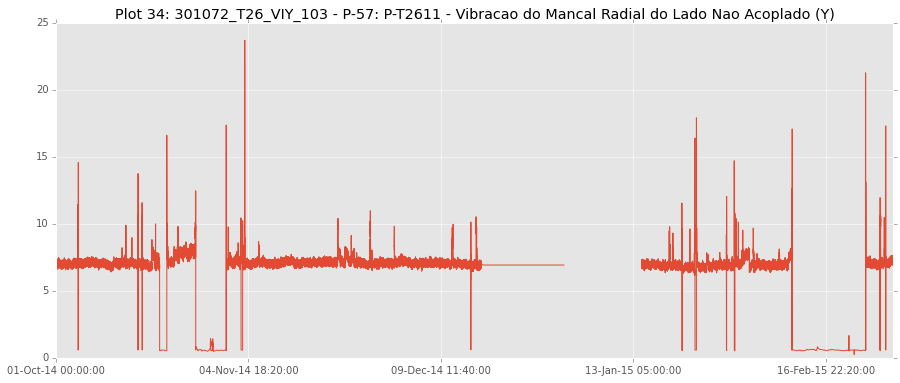

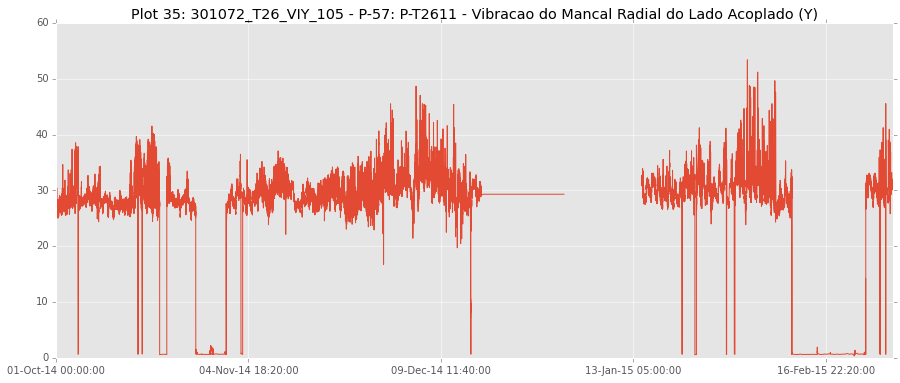

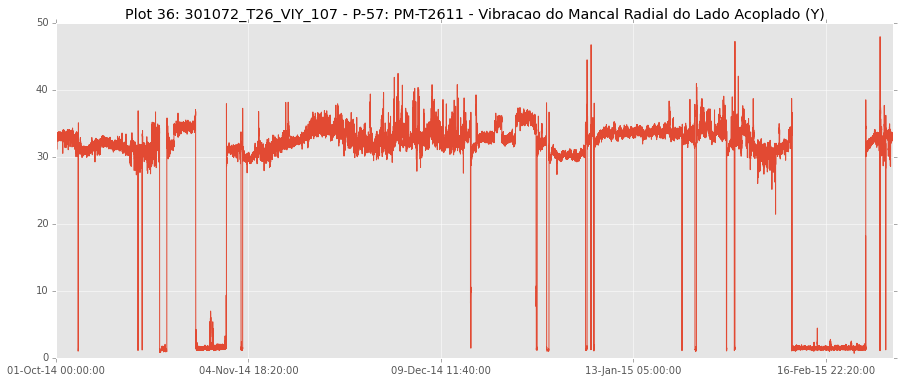

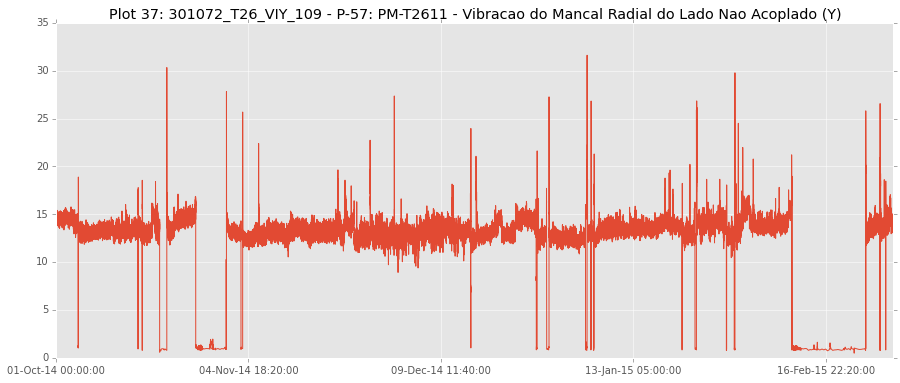

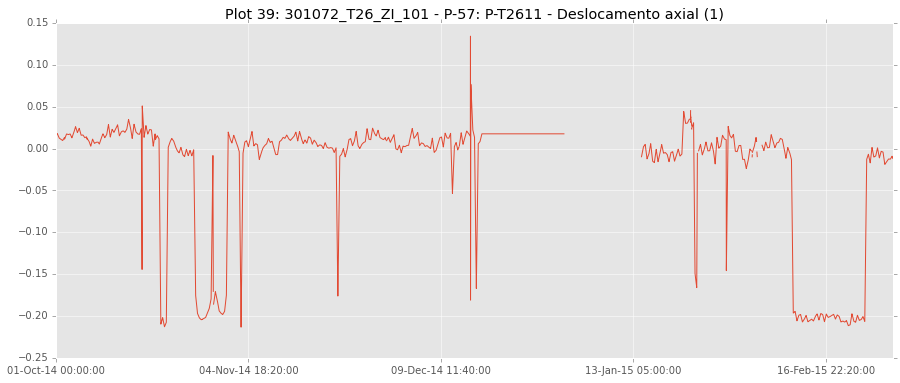

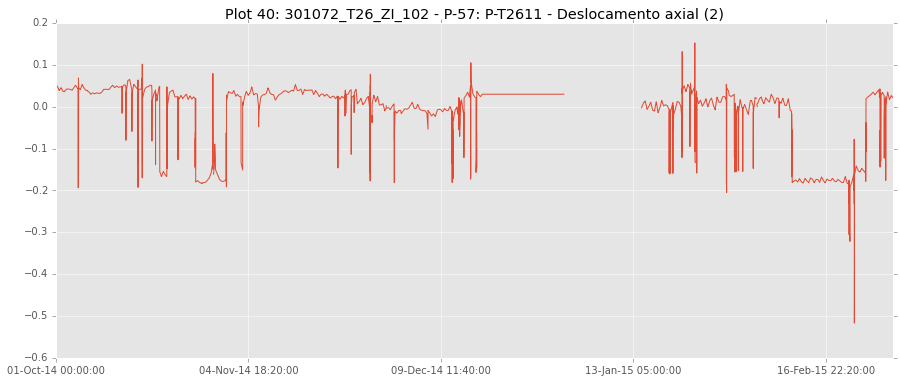

In [5]:
data_frame = pd.DataFrame(data=orig_data,
                          index=orig_data['1m'],
                          columns=names)

n_features = len(names)
for i in (np.arange(n_features-1)+1):
    if data_frame[names[i]].dtype == 'object':
        print 'Categorical Data. No plot shown.'
        print 'Variable {}: {} - {}'.format(i, names[i], descriptions[i-1])
        print data_frame[names[11]].value_counts()
    else:
        plt.style.use('ggplot')
        plt.figure(figsize=(15, 6))
        plt.title('Plot {}: {} - {}'.format(i, names[i], descriptions[i-1]))
        data_frame[names[i]].plot()